## FTEC2101/ESTR2520 Practical Project 2022

The aim of this project is to solve various forms of the binary classification problem through Julia/computer software. This program template will provide hints/template code for you to focus on the optimization formulation part.

As usual, we first need to load a few packages in Julia.

In [1]:
# Load the JuMP related packages and several solvers
# ECOS - for solving SOCP problems
# Juniper & Ipopt - for solving MI-NLP problems
using JuMP, Juniper, ECOS, Ipopt
# Load the data/file processing related packages
using CSV, DataFrames, Statistics
# Load the Plot package for illustrating the solution
using Plots
# We also need some linear algebra functions
using LinearAlgebra

## Compulsory Tasks 

Our first step is to load both the training and testing dataset into the memory. Change the files names to the group id that you are assigned.

In [2]:
cs_data = DataFrame( CSV.File( "./ftec-cs-group2-train.csv" , missingstring=["NA", ""] ) ); 
cs_data_test = DataFrame( CSV.File( "./ftec-cs-group2-test.csv" , missingstring=["NA", ""] ) );

The above code should have loaded the training dataset (resp. testing dataset) into the memory and stored them into the variable "cs_data" (resp. "cs_data_test") as a DataFrame object. Now, you may execute the following line to inspect what is in the training dataset.

In [3]:
print(cs_data)

20×8 DataFrame
 Row │ RevolvingUtilizationOfUnsecuredLines  age       DebtRatio     MonthlyIncome  NumberOfOpenCreditLinesAndLoans  NumberRealEstateLoansOrLines  NumberOfDependents  Default 
     │ Float64                               Float64   Float64       Float64        Float64                          Float64                       Float64             Bool    
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │                           0.0615903   0.318314   0.642265          0.016388                        0.054323                     0.0603497           0.00137082    false
   2 │                           0.51958     0.426459   0.160788          0.021316                        0.0746833                    0.0234451           0.117363      false
   3 │                           1.0         0.395865   0.00319489        0.0964                          0

We should observe that the training dataset consists of 20 rows and 8 columns. The first 7 columns consist of "RevolvingUtilizationOfUnsecuredLines", "age", "DebtRatio", "MonthlyIncome", "NumberOfOpenCreditLinesAndLoans", "NumberRealEstateLoansOrLines", "NumberOfDependents" of the customer; and the 8th column named "Default" indicates if the customer has a history of default or not.

### **Task 4**: Getting familiar with the dataset

Next, we select a few pairs of features to make scatter plots and observe the pattern. The first example pair of "RevolvingUtilizationOfUnsecuredLines", "NumberOfOpenCreditLinesAndLoans" is done in the helper code below.  Use "Insert" -> "Insert Cell Below/After" if you want to keep the plots together in one place.

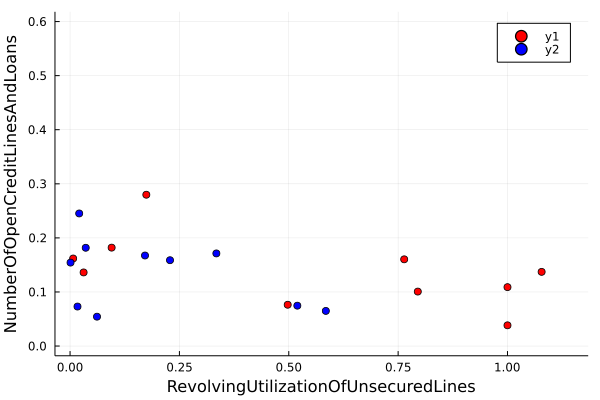

In [4]:
# the following code extracts the columns with specific labels from the dataframe "cs_data" and turn 
# the corresponding dataset into a numerical matrix 
feat_vec_plot = Matrix( cs_data[!, [ "RevolvingUtilizationOfUnsecuredLines", "NumberOfOpenCreditLinesAndLoans" ]] )

# find the indices of the default and non-default customers
pos_idx = findall(cs_data.Default .== 1);
neg_idx = findall(cs_data.Default .== 0);

# the scatter plot for the selected features
scatter( feat_vec_plot[pos_idx,1], feat_vec_plot[pos_idx,2] , color="red")
scatter!( feat_vec_plot[neg_idx,1], feat_vec_plot[neg_idx,2] , color="blue", 
    xlims = [0,1.15], ylims = [0,0.6], 
    xlabel = "RevolvingUtilizationOfUnsecuredLines", ylabel = "NumberOfOpenCreditLinesAndLoans")
# note that "xlims", "ylims" controls the range of x/y-axis of the plot 
# "xlabel", "ylabel" controls the labels put on the x/y-axis 
# you may have to adjust them to produce more a readable/nicer figure. 

# the figure can be saved into an png using the following command - please uncomment it and re-run the code
# if you'd like to save a png file.
# savefig("scatter-1.png")

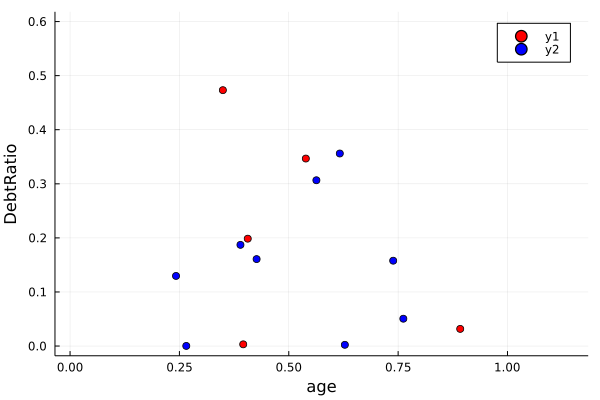

In [5]:
# the following code extracts the columns with specific labels from the dataframe "cs_data" and turn 
# the corresponding dataset into a numerical matrix 
feat_vec_plot = Matrix( cs_data[!, [ "age", "DebtRatio" ]] )

# find the indices of the default and non-default customers
pos_idx = findall(cs_data.Default .== 1);
neg_idx = findall(cs_data.Default .== 0);

# the scatter plot for the selected features
scatter( feat_vec_plot[pos_idx,1], feat_vec_plot[pos_idx,2] , color="red")
scatter!( feat_vec_plot[neg_idx,1], feat_vec_plot[neg_idx,2] , color="blue", 
    xlims = [0,1.15], ylims = [0,0.6], 
    xlabel = "age", ylabel ="DebtRatio")
# note that "xlims", "ylims" controls the range of x/y-axis of the plot 
# "xlabel", "ylabel" controls the labels put on the x/y-axis 
# you may have to adjust them to produce more a readable/nicer figure. 

# the figure can be saved into an png using the following command - please uncomment it and re-run the code
# if you'd like to save a png file.
# savefig("scatter-1.png")

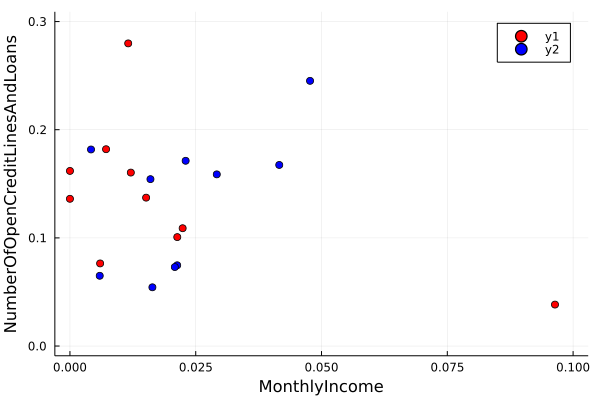

In [6]:
# the following code extracts the columns with specific labels from the dataframe "cs_data" and turn 
# the corresponding dataset into a numerical matrix 
feat_vec_plot = Matrix( cs_data[!, [ "MonthlyIncome", "NumberOfOpenCreditLinesAndLoans" ]] )

# find the indices of the default and non-default customers
pos_idx = findall(cs_data.Default .== 1);
neg_idx = findall(cs_data.Default .== 0);

# the scatter plot for the selected features
scatter( feat_vec_plot[pos_idx,1], feat_vec_plot[pos_idx,2] , color="red")
scatter!( feat_vec_plot[neg_idx,1], feat_vec_plot[neg_idx,2] , color="blue", 
    xlims = [0,0.1], ylims = [0,0.3], 
    xlabel = "MonthlyIncome", ylabel ="NumberOfOpenCreditLinesAndLoans")
# note that "xlims", "ylims" controls the range of x/y-axis of the plot 
# "xlabel", "ylabel" controls the labels put on the x/y-axis 
# you may have to adjust them to produce more a readable/nicer figure. 

# the figure can be saved into an png using the following command - please uncomment it and re-run the code
# if you'd like to save a png file.
# savefig("scatter-1.png")

Before we proceed to the computational stage, let us extract the required data from the dataframes and store them into some matrices in Julia.

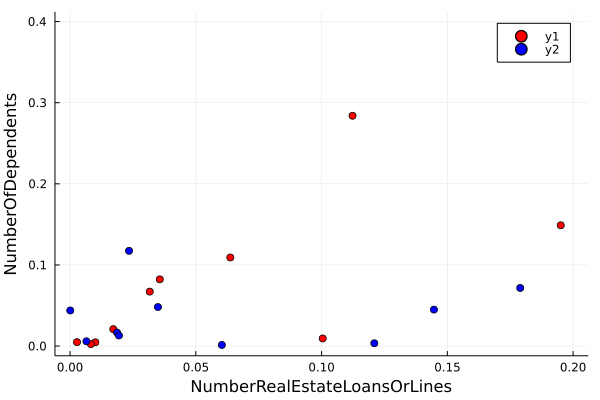

In [7]:
# the following code extracts the columns with specific labels from the dataframe "cs_data" and turn 
# the corresponding dataset into a numerical matrix 
feat_vec_plot = Matrix( cs_data[!, [ "NumberRealEstateLoansOrLines", "NumberOfDependents"]] )

# find the indices of the default and non-default customers
pos_idx = findall(cs_data.Default .== 1);
neg_idx = findall(cs_data.Default .== 0);

# the scatter plot for the selected features
scatter( feat_vec_plot[pos_idx,1], feat_vec_plot[pos_idx,2] , color="red")
scatter!( feat_vec_plot[neg_idx,1], feat_vec_plot[neg_idx,2] , color="blue", 
    xlims = [0,0.2], ylims = [0,0.4], 
    xlabel = "NumberRealEstateLoansOrLines", ylabel = "NumberOfDependents")
# note that "xlims", "ylims" controls the range of x/y-axis of the plot 
# "xlabel", "ylabel" controls the labels put on the x/y-axis 
# you may have to adjust them to produce more a readable/nicer figure. 

# the figure can be saved into an png using the following command - please uncomment it and re-run the code
# if you'd like to save a png file.
# savefig("scatter-1.png")

In [8]:
# as specified in the project spec, we take the following two features for our Task 5-6
feat_vec = Matrix( cs_data[!, [ "RevolvingUtilizationOfUnsecuredLines", "NumberOfOpenCreditLinesAndLoans" ]] )
# We convert the "true/false" labels into "+1"/"-1" numbers for easier manipulations
label_vec = 2*cs_data.Default .- 1;

# the following codes does the same for the testing dataset
feat_vec_test = Matrix( cs_data_test[!, [ "RevolvingUtilizationOfUnsecuredLines", "NumberOfOpenCreditLinesAndLoans" ]] )
# We convert the "true/false" labels into "+1"/"-1" numbers for easier manipulations
label_vec_test = 2*cs_data_test.Default .- 1;

Note that "feat_vec" is a 20x2 matrix whose rows are the feature vectors $x^{(i)}$; and "label_vec" is a 20x1 vector that corresponds to the labels of $\{ \pm 1 \}$.

### Task 5-a: The Mixed IP Problem

We now consider Task 5-a in which we shall program the MIP-NLP problem:

In [9]:
nl_solver = optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0)
optimizer = Juniper.Optimizer

m = 20; M = 100;

model_ip = Model(optimizer_with_attributes(optimizer, "nl_solver"=>nl_solver, "atol"=>1e-10))
d=2
@variable(model_ip, w_ip[1:d])
@variable(model_ip, b_ip)
@variable(model_ip, z_ip[1:m],Bin)
@variable(model_ip, F_ip[1:m])
@NLconstraint(model_ip,(1/200)*sum(w_ip[i]^2 for i in 1:d)<=1) 
for i=1:m
    @constraint(model_ip,z_ip[i]<=M*F_ip[i])
    @constraint(model_ip,F_ip[i]<=M*z_ip[i])
    @constraint(model_ip,0<=F_ip[i]<=M)
    @constraint(model_ip, label_vec[i]*feat_vec[i,:]'*w_ip .+ label_vec[i]*b_ip>=1-F_ip[i])
end
@objective(model_ip,Min,sum(z_ip))
optimize!(model_ip)
# Program the MIP formulation below.
# (You may want to call the decision variables in your MIP formulation as "w_ip", "b_ip" to be 
# compatible with the helper code below)



atol              : 1.0e-10
nl_solver         : MathOptInterface.OptimizerWithAttributes(Ipopt.Optimizer, Pair{MathOptInterface.AbstractOptimizerAttribute, Any}[MathOptInterface.RawOptimizerAttribute("print_level") => 0])
feasibility_pump  : false
log_levels        : [:Options, :Table, :Info]

#Variables: 43
#IntBinVar: 20
Obj Sense: Min


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Start values are not feasible.
Status of relaxation: LOCALLY_SOLVED
Time for relaxation: 8.960999965667725
Relaxation Obj: 0.12323807030773494

 ONodes   CLevel          Incumbent                   BestBound            Gap    Time   Restarts  GainGap  
    2       2      

   48       10                -                          4.12               -     9.0       -       94.3%   
   48       11                -                          4.12               -     9.0       -       93.6%   
   49       8                 -                          4.13               -     9.1       -       98.7%   
   49       9                 -                          4.13               -     9.2       -       95.1%   
   50       7                 -                          4.14               -     9.2       -       98.8%   
   50       8                 -                          4.14               -     9.2       -       95.8%   
   50       9                 -                          4.16               -     9.3       -       96.4%   
   51       7                 -                          4.16               -     9.4       -       99.0%   
   51       8                 -                          4.16               -     9.4       -       96.8%   
   51       8      

You can program the MI-NLP problem in the following cell and solve it. Here are a few hints that maybe useful.

- To be compatible with the helper codes in the latter section, please call the decision variables by "w_ip", "b_ip". 
- You may use for-loop to specify a large number of constraints. 
- To model constraint given in the form of 
$$ \sum_{i=1}^d x_i y_i \geq r $$
with the $d$-dimensional vectors $x$, $y$. You may do so by

$$ \texttt{@constraint(model, sum( x .* y ) >= r)} $$

where $\texttt{.*}$ denotes an "element-wise" product. (You may have to combine the above part with other simpler arithmetic operations).
- To include quadratic constraint of the form
$$ f(x) = x^\top x \leq 1 $$

the above can be modeled in JuMP by

$$ \texttt{@NLconstraint( model, sum(x[i]^2 for i in 1:d) <= 1 )} $$

Notice that we shall use "$\texttt{NLconstraint}$ to specify that the constraint involves a nonlinear function.

We can inspect the result from solving the MIP problem as follows:

In [10]:
# we store the classifier optimized in the variables "w_res_ip", "b_res_ip" 
# (you may change these variable names to anything you like)

w_res_ip = JuMP.value.(w_ip); b_res_ip = JuMP.value.(b_ip);
print( "w = ", w_res_ip , ", b = ",b_res_ip , ", obj value = ", objective_value(model_ip) )

w = [13.486306484136774, 1.9151887619278318], b = -9.294570194931117, obj value = 5.0

### **Task 5-b**: Formulate the SOCP Problem

We next consider solving the SOCP problem:

In [11]:
m = 20;
model_socp = Model(ECOS.Optimizer)

# Program the SOCP formulation below.
# (You may want to call the decision variables in your SOCP formulation as "w_socp", "b_socp" to be 
# compatible with the helper code below)
d=2;
@variable(model_socp,t_socp[1:d+m+1])
A=zeros(d+m+1)
B=zeros(m,d+m+1)
C=zeros(m,d+m+1)
for i=d+2:d+m+1
    A[i]=1
end

for i=1:m
    B[i,d+1+i]=1
end

for i=1:m
    for j=1:d
        C[i,j]=label_vec[i]*feat_vec[i,j]
    end
    C[i,d+1]=label_vec[i]
    C[i,d+1+i]=1
end

for i=1:m
    @constraint(model_socp,C[i,:]'*t_socp>=1)
    @constraint(model_socp,B[i,:]'*t_socp>=0)
end
T=[t_socp[1];t_socp[2]]
@constraint(model_socp, [1; T.*(1/sqrt(200))] in SecondOrderCone() );
@objective(model_socp,Min,A'*t_socp);
optimize!(model_socp)
b_socp=t_socp[d+1]
w_socp=t_socp[1:d]

2-element Vector{VariableRef}:
 t_socp[1]
 t_socp[2]


ECOS 2.0.8 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +7.738e+000  +3.177e+001  +1e+002  5e-001  8e-001  1e+000  3e+000    ---    ---    1  1  - |  -  - 
 1  +1.138e+001  +1.543e+001  +4e+001  5e-002  1e-001  9e-001  9e-001  0.8564  1e-001   1  1  1 |  0  0
 2  +1.210e+001  +1.304e+001  +9e+000  1e-002  3e-002  2e-001  2e-001  0.7684  3e-002   1  1  1 |  0  0
 3  +1.230e+001  +1.255e+001  +2e+000  3e-003  9e-003  5e-002  6e-002  0.7794  6e-002   1  1  1 |  0  0
 4  +1.232e+001  +1.235e+001  +4e-001  3e-004  1e-003  6e-003  9e-003  0.8971  5e-002   1  1  1 |  0  0
 5  +1.232e+001  +1.234e+001  +2e-001  2e-004  6e-004  2e-003  4e-003  0.6434  2e-001   1  1  1 |  0  0
 6  +1.232e+001  +1.232e+001  +5e-003  5e-006  2e-005  5e-005  1e-004  0.9835  1e-002   1  1  1 |  0  0
 7  +1.232e+001  +1.232e+001  +5e-005  5e-008  2e-007  6e-007  1e-006  0.9890  1e-004  

You may program the SOCP problem into JuMP as follows. Again, for convenience, you may name the decision variables as "w_socp", "b_socp". 

Further, wou may find that some constraints are similar to the MI-NLP from the previous task. However, when you "copy-and-paste" those code, don't forget to change the model name and the variable name. Here are some hints on modeling the second order cone constraints:

- To model a SOC constraint given in the form

$$ \| Ax + d \| \leq c^\top x + d, $$

you can use

$$ \texttt{ @constraint( m_socp, [c'*x + d; A*x + d] in SecondOrderCone() ) } $$

Essentially, "$\texttt{[c'*x + d; A*x + d]}$" defines a vector whose first element describes the RHS of the SOC constraint, the the remaining elements describe the vector found inside the norm of the SOC constraint. 

In [12]:
# we store the classifier optimized in the variables "w_res_socp", "b_res_socp"
# (you may change these names to anything you like)

w_res_socp = JuMP.value.(w_socp); b_res_socp = JuMP.value.(b_socp);
print( "w = ", w_res_socp , ", b = ",b_res_socp , ", obj value = ", objective_value(model_socp) )

w = [4.057460889755583, 13.336089732232177], b = -3.568781994269584, obj value = 12.323793151293632

### **Task 5-c**: Visualizing the classifier

Below, we overlay the classifiers designed in Task 5-a, 5-b on the scatter plot for this set of features.

In Julia, you may plot a 1-D function such as $y = f(x)$ using the command "plot!(x,y)" where "x" is a vector of the range (e.g., an array of values from 0 to 1) and "y" is a vector consisting of the function values. 

Now, the classifier with $d=2$ can also be seen as a straight line such that with 

$$ \texttt{w[1]*x + w[2]*y + b = 0} 
$$

where $\texttt{x}$ represents the RevolvingUtilizationOfUnsecuredLines, and $\texttt{y}$ represents the NumberOfOpenCreditLinesAndLoans. So, to plot the classifier, we simply have to substitute a range of values for "x" and compute the corresponding values of "y" according to the above equation. 

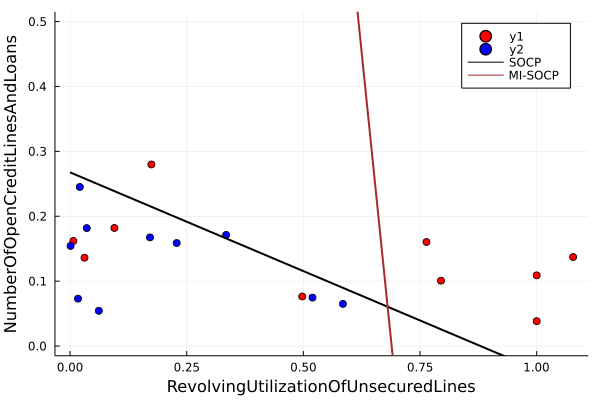

In [13]:
# the following two fines are almost identical to Task 4
scatter( feat_vec[pos_idx,1], feat_vec[pos_idx,2] , color="red" )
scatter!( feat_vec[neg_idx,1], feat_vec[neg_idx,2] , color="blue" , 
    xlabel = "RevolvingUtilizationOfUnsecuredLines", ylabel = "NumberOfOpenCreditLinesAndLoans" )

# Write the code to plot the classifiers below, to create an array of values from 0 to 1.05 with an equal spacing
# of 0.05, you may use the following code:
x_range = collect(0:0.05:1.05)
# to make a nicer plot, sometimes you will have to adjust the range in the above slightly.

dimen=size(x_range,1)
y_ip = zeros(dimen)
y_socp = zeros(dimen)
for i=1:dimen
    y_ip[i]=(-w_res_ip[1]*x_range[i]-b_res_ip)/w_res_ip[2]
end

for i=1:dimen
    y_socp[i]=(-w_res_socp[1]*x_range[i]-b_res_socp)/w_res_socp[2]
end


plot!( x_range, y_socp, color="black", linewidth=2, ylims = [0,0.5], label = "SOCP") 

plot!( x_range, y_ip, color="brown", linewidth=2, ylims = [0,0.5], label = "MI-SOCP") 
# change "*" in the above to be a function of "x_range" and the classifiers found with Task 5-a/5-b.

### **Task 6**: Evaluating the Error Performance 

In this task, we shall construct a function that takes the training/testing data, a designed classifier as the input, and returns the error rate. You may refer to the "err_rate" function used in Computing Lab 2 to get some inspiration.

In [14]:
function error_rate( feat_vec, label_vec, w, b)
    # write a function to calculate the error rate of the classifier (w,b) on the 
    # matrix of feature vectors "feat_vec" and corresponding labels "label_vec"
    # the no. of rows/columns in a vector can be conveniently obtained by the function "size()"
    # e.g., the no. of rows/columns in "feat_vec" can be found by "size( feat_vec, 1 )", "size( feat_vec, 2)", respectively
    error=0;
    y=0;
    for i=1:size(feat_vec,1)
        if feat_vec[i,:]'*w .+ b>=0
            y=1
        else y=-1
        end
        if label_vec[i]!=y
            error = error +1
        end 
    end   
    return error/size(feat_vec,1)
end

error_rate (generic function with 1 method)

Now, apply the function to compute the error rates of the different classifiers:

In [15]:
print( "Training error rate of MIP = ", error_rate( feat_vec, label_vec, w_res_ip, b_res_ip ), 
    ", Training error rate of SOCP = ", error_rate( feat_vec, label_vec, w_res_socp, b_res_socp ), "\n" )

print( "Test error rate of MIP = ", error_rate( feat_vec_test, label_vec_test, w_res_ip, b_res_ip ), 
    ", Test error rate of SOCP = ", error_rate( feat_vec_test, label_vec_test, w_res_socp, b_res_socp ), "\n" )

Training error rate of MIP = 0.25, Training error rate of SOCP = 0.25
Test error rate of MIP = 0.2, Test error rate of SOCP = 0.2


### **Task 7**: Classifier with the Full Feature Set

Below, we repeat Task 5 while considering the full set of features. 

In [16]:
# we first extract the full feature matrices
feat_vec_full = Matrix( cs_data[!, [ "RevolvingUtilizationOfUnsecuredLines", "NumberOfOpenCreditLinesAndLoans", 
            "age", "DebtRatio", "MonthlyIncome", "NumberRealEstateLoansOrLines", "NumberOfDependents" ]] )
feat_vec_full_test = Matrix( cs_data_test[!, [ "RevolvingUtilizationOfUnsecuredLines", "NumberOfOpenCreditLinesAndLoans", 
            "age", "DebtRatio", "MonthlyIncome", "NumberRealEstateLoansOrLines", "NumberOfDependents" ]] )
# We convert the "true/false" labels into "+1"/"-1" numbers for easier manipulations
label_vec = 2*cs_data.Default .- 1;

**MIP Formulation**:

In [17]:
nl_solver = optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0)
optimizer = Juniper.Optimizer

m = 20; M = 100;

model_ip = Model(optimizer_with_attributes(optimizer, "nl_solver"=>nl_solver, "atol"=>1e-10))

# Program the MIP formulation below.
# (You may want to call the decision variables in your MIP formulation as "w_ip_full", "b_ip_full" to be 
# compatible with the helper code below)
d=7
@variable(model_ip, w_ip_full[1:d])
@variable(model_ip, b_ip_full)
@variable(model_ip, z_ip[1:m],Bin)
@variable(model_ip, F_ip[1:m])
@NLconstraint(model_ip,(1/200)*sum(w_ip_full[i]^2 for i in 1:d)<=1) 
for i=1:m
    @constraint(model_ip,z_ip[i]<=M*F_ip[i])
    @constraint(model_ip,F_ip[i]<=M*z_ip[i])
    @constraint(model_ip,0<=F_ip[i]<=M)
    @constraint(model_ip, label_vec[i]*feat_vec_full[i,:]'*w_ip_full .+ label_vec[i]*b_ip_full>=1-F_ip[i])
end
@objective(model_ip,Min,sum(z_ip))
optimize!(model_ip)
# Program the MIP formulation below.
# (You may want to call the decision variables in your MIP formulation as "w_ip", "b_ip" to be 
# compatible with the helper code below)



atol              : 1.0e-10
nl_solver         : MathOptInterface.OptimizerWithAttributes(Ipopt.Optimizer, Pair{MathOptInterface.AbstractOptimizerAttribute, Any}[MathOptInterface.RawOptimizerAttribute("print_level") => 0])
feasibility_pump  : false
log_levels        : [:Options, :Table, :Info]

#Variables: 48
#IntBinVar: 20
Obj Sense: Min

Start values are not feasible.
Status of relaxation: LOCALLY_SOLVED
Time for relaxation: 0.15400004386901855
Relaxation Obj: 0.03323787811807387

 ONodes   CLevel          Incumbent                   BestBound            Gap    Time   Restarts  GainGap  
    2       2                 -                          0.03               -     0.9       0         -     
    3       3                 -                          0.03               -     0.9       -       85.4%   
    4       4                 -                          0.05               -     1.0       -       95.8%   
    4       5                 -                          0.13               -

In [18]:
# print out the SOCP solution
w_res_ip_full = JuMP.value.(w_ip_full); b_res_ip_full = JuMP.value.(b_ip_full);
print( "w = ", w_res_ip_full , ", b = ",b_res_ip_full , ", obj value = ", objective_value(model_ip) )

w = [6.941530557892784, -0.029385719996244074, 11.730191238905991, 1.0033960990603525, -0.030829113169963295, 0.7337097323093396, 2.99482996046115], b = -10.395490248989322, obj value = 2.0

In [19]:
print( "Training error rate of MIP = ", error_rate( feat_vec, label_vec, w_res_ip, b_res_ip ), 
    ", Training error rate of MIP (Full) = ", error_rate( feat_vec_full, label_vec, w_res_ip_full, b_res_ip_full ), "\n" )

print( "Test error rate of MIP = ", error_rate( feat_vec_test, label_vec_test, w_res_ip, b_res_ip ), 
    ", Test error rate of MIP (Full) = ", error_rate( feat_vec_full_test, label_vec_test, w_res_ip_full, b_res_ip_full ), "\n" )

Training error rate of MIP = 0.25, Training error rate of MIP (Full) = 0.1
Test error rate of MIP = 0.2, Test error rate of MIP (Full) = 0.26666666666666666


**SOCP Formulation**:

In [20]:
m = 20;
model_socp = Model(ECOS.Optimizer)

# Program the SOCP formulation below.
# (You may want to call the decision variables in your SOCP formulation as "w_socp_full", "b_socp_full" to be 
# compatible with the helper code below)
d=7;
@variable(model_socp,t_socp[1:d+m+1])
A=zeros(d+m+1)
B=zeros(m,d+m+1)
C=zeros(m,d+m+1)
for i=d+2:d+m+1
    A[i]=1
end

for i=1:m
    B[i,d+1+i]=1
end

for i=1:m
    for j=1:d  
      C[i,j]=label_vec[i]*feat_vec_full[i,j]
    end
    C[i,d+1]=label_vec[i]
    C[i,d+1+i]=1
end

for i=1:m
    @constraint(model_socp,C[i,:]'*t_socp>=1)
    @constraint(model_socp,B[i,:]'*t_socp>=0)
end
T=zeros(d+m+1)
for i=1:d
    T[i]=1/sqrt(200)
end
@constraint(model_socp, [1; sum(T[i]*t_socp[i] for i=1:d )] in SecondOrderCone() );
@objective(model_socp,Min,A'*t_socp);
optimize!(model_socp)
b_socp_full=t_socp[d+1]
w_socp_full=t_socp[1:d]




ECOS 2.0.8 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.574e+000  +2.199e+001  +1e+002  4e-001  8e-001  1e+000  3e+000    ---    ---    1  1  - |  -  - 
 1  +4.555e+000  +9.491e+000  +4e+001  7e-002  2e-001  8e-001  1e+000  0.7094  1e-001   1  1  1 |  0  0
 2  +2.890e+000  +5.792e+000  +2e+001  3e-002  2e-001  5e-001  5e-001  0.6788  2e-001   1  1  1 |  0  0
 3  +2.037e+000  +3.529e+000  +7e+000  1e-002  9e-002  3e-001  2e-001  0.7574  2e-001   1  1  1 |  0  0
 4  +6.407e-001  +1.127e+000  +2e+000  4e-003  3e-002  9e-002  5e-002  0.7947  1e-001   1  1  1 |  0  0
 5  +1.690e-002  +3.000e-002  +6e-002  1e-004  1e-003  2e-003  1e-003  0.9798  7e-003   1  1  1 |  0  0
 6  +1.887e-004  +3.341e-004  +7e-004  1e-006  1e-005  2e-005  2e-005  0.9890  1e-004   1  1  1 |  0  0
 7  +2.105e-006  +3.718e-006  +7e-006  1e-008  1e-007  3e-007  2e-007  0.9890  1e-004  

7-element Vector{VariableRef}:
 t_socp[1]
 t_socp[2]
 t_socp[3]
 t_socp[4]
 t_socp[5]
 t_socp[6]
 t_socp[7]

In [21]:
# print out the SOCP solution
w_res_socp_full = JuMP.value.(w_socp_full); b_res_socp_full = JuMP.value.(b_socp_full);


print( "w = ", w_res_socp_full , ", b = ",b_res_socp_full , ", obj value = ", objective_value(model_socp) )

w = [24.302331891484148, 30.478512521888902, 18.858259184534866, 0.3719122414149733, -45.26206255786156, -5.939667234902679, -29.106450300873902], b = -20.513745968909383, obj value = 2.636903030263643e-10

In [22]:
print( "Training error rate of SOCP = ", error_rate( feat_vec, label_vec, w_res_socp, b_res_socp ), 
    ", Training error rate of SOCP (Full) = ", error_rate( feat_vec_full, label_vec, w_res_socp_full, b_res_socp_full ), "\n" )

print( "Test error rate of SOCP = ", error_rate( feat_vec_test, label_vec_test, w_res_socp, b_res_socp ), 
    ", Test error rate of SOCP (Full) = ", error_rate( feat_vec_full_test, label_vec_test, w_res_socp_full, b_res_socp_full ), "\n" )

Training error rate of SOCP = 0.25, Training error rate of SOCP (Full) = 0.0
Test error rate of SOCP = 0.2, Test error rate of SOCP (Full) = 0.26666666666666666


## Competitive Tasks

As the last part of this project, we will build a customized solver for designing the binary classifier using a large number of training samples (around 16k of them).

We first prepare the data by loading them into the memory with the following helper code. 

In [23]:
cs_data_full = DataFrame( CSV.File( "./ftec-cs-full-train.csv" , missingstring=["NA", ""] ) );
# create a matrix of the full data
feat_vec_all_full = Matrix( cs_data_full[!, [ "RevolvingUtilizationOfUnsecuredLines", "NumberOfOpenCreditLinesAndLoans", 
            "age", "DebtRatio", "MonthlyIncome", "NumberRealEstateLoansOrLines", "NumberOfDependents" ]] );
label_vec_all_full = 2 .* cs_data_full.Default .- 1;
m = length( label_vec_all_full ) # storing the no of samples as "m".

16657

In [24]:
# Here is the testing dataset
cs_data_full_test = DataFrame( CSV.File( "./ftec-cs-full-test.csv" , missingstring=["NA", ""] ) );
# create a matrix of the full data
feat_vec_all_full_test = Matrix( cs_data_full_test[!, [ "RevolvingUtilizationOfUnsecuredLines", "NumberOfOpenCreditLinesAndLoans", 
            "age", "DebtRatio", "MonthlyIncome", "NumberRealEstateLoansOrLines", "NumberOfDependents" ]] );
label_vec_all_full_test = 2 .* cs_data_full_test.Default .- 1;

As mentioned in the appendix of the project spec, it maybe worthwhile to inspect the norm of the feature vectors in "feat_vec_all_full"

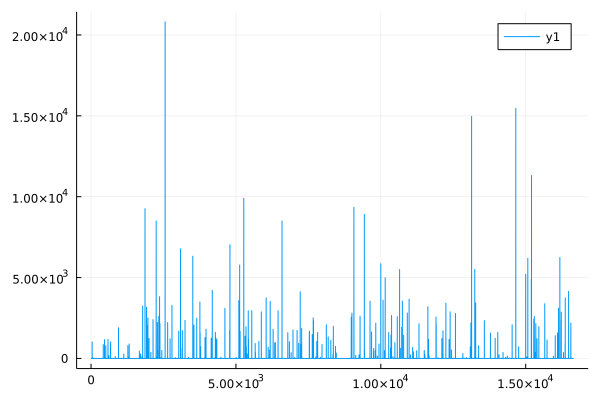

In [25]:
norm_feature = [ norm( feat_vec_all_full[i,:] ) for i in 1:m ];
plot( norm_feature )

In [26]:
# especially you can count the number of training sample with a large ||x^i||, e.g., > 1000 by
# recalling that there are m = 16557 samples in total! 
print("no of samples with ||xi||>=1e3 = ", sum( norm_feature .>= 1000 ))

no of samples with ||xi||>=1e3 = 141

In [27]:
# when programing the loss function and/or its gradient involving the exponential function, 
# use the following modified "exp_limit" to replace the default "exp" which will have better numerical stability.

function exp_limit( x )
    return exp( min(x,500.0) )
end

function projection_L2( w )
    # program the function to calculate the projection operator
    if norm(w)<=1
        return w
    else return  1/norm(w) .* w
    end
end
# you are recommended to try with the logistic loss first
# but feel free to use other alternatives
function logistic_loss( feat_vec, label_vec, w, b, L )
    # program the function to calculate the logistic loss 
    # you may take the input "L" as a mx1 vector of the weights l_i
    m=size(feat_vec,1)
    return sum(L[i]* log(1+exp_limit(-label_vec[i]feat_vec[i,:]'w .- label_vec[i]*b)) for i in 1:m) 
end

function logistic_grad( feat_vec, label_vec, w, b, L )
    # program the function to calculate the logistic loss's gradient
    # you may take the input "L" as a mx1 vector of the weights l_i
    m=size(feat_vec,1)
    d=size(feat_vec,2)
    grad=zeros(d+1)

    for j=1:d
        K=0.0
        for i=1:m
            yx= -label_vec[i]*feat_vec[i,j]
            K = K + L[i]*yx*exp_limit(-label_vec[i]*feat_vec[i,:]'*w .- label_vec[i]*b)/(1+
                exp_limit(-label_vec[i]*feat_vec[i,:]'*w .- label_vec[i]*b))
        end
        grad[j]= K / m
    end
    K=0.0
    for i=1:m
        K= K + L[i]*(-label_vec[i])*exp_limit(-label_vec[i]*feat_vec[i,:]'*w .- label_vec[i]*b)/(1+exp_limit(-label_vec[i]*feat_vec[i,:]'*w .- label_vec[i]*b))
    end
    grad[1+d]=K / m
    return grad
end


logistic_grad (generic function with 1 method)

Remark: think about how to deal with those samples with large $||x^i||$. 

We may now apply gradient based method to learn the binary classifier. 

First, we shall construct a few functions for evaluating the gradient / loss value; as well as the projection function onto the L2 norm ball. The below skeleton functions are named after "logistic_" suggesting that you may try out the logistic loss function first. However, feel free to use other formulation as well:



function exp_limit( x )
    return exp( min(x,500.0) )
end

function projection_L2( w )
    # program the function to calculate the projection operator
    if norm(w)<=1
        return w
    else return  1/norm(w) .* w
    end
end


function logistic_loss( feat_vec, label_vec, w, b, L )
    # program the function to calculate the logistic loss 
    # you may take the input "L" as a mx1 vector of the weights l_i
    
    L=fill()
end

function logistic_grad( feat_vec, label_vec, w, b, L )
    # program the function to calculate the logistic loss's gradient
    # you may take the input "L" as a mx1 vector of the weights l_i
    
end

In [28]:
# Program an iterative algorithm for solving (1.8) below.

# initialization and set the parameters 
w0 = zeros(7); b0 = 0; # you must initialize by w = 0, b = 0

# initialize the algorithm
w_log = copy(w0); b_log = copy(b0); 
# copy the variable and update w_log, b_log instead of w0, b0 

store_obj = []; # use this array to store the objective value

m=size(feat_vec_all_full,1)
d=size(feat_vec_all_full,2)
L_all=fill(1.0,m)

push!(store_obj, logistic_loss(feat_vec_all_full,label_vec_all_full,w_log,b_log,L_all) ) # replace ".." with the function you wrote for computing the objective val.

for iteration_no = 1 : 500 # adjust the number of iterations run here.
    # your code here
    gamma= 1/iteration_no
    w0= w_log
    w_log= projection_L2(w_log-gamma*logistic_grad(feat_vec_all_full,label_vec_all_full,w_log,b_log,L_all)[1:d])
    b_log= b_log-gamma*logistic_grad(feat_vec_all_full,label_vec_all_full,w0,b_log,L_all)[1+d]
    # tracking the progress of the algorithm 
    # note that calculating the gradient, objective function, etc. for ** tracking the progress of algo. ** 
    # as required by Task 8 does not count towards the total no. of accesses to the training dataset 
    # ** AS LONG AS ** the information obtained herein are not used in the update of algorithm  
    
    push!(store_obj, logistic_loss(feat_vec_all_full,label_vec_all_full,w_log,b_log,L_all)) # replace ".." with the function you wrote for computing the objective val.
    
end

The following code shows the trajectory of the objective values against the iteration number

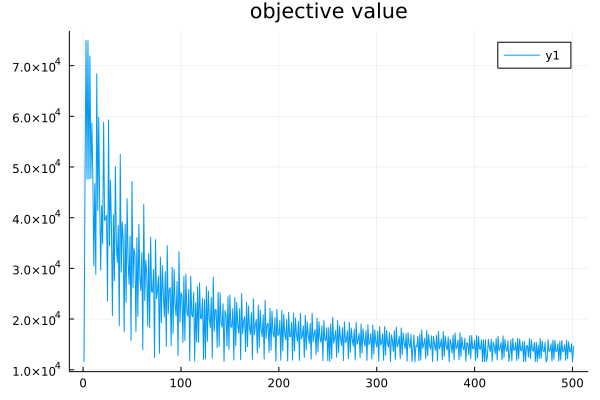

In [29]:
plot( store_obj, title = "objective value" )

Inspecting the solution and computing its error rate performance:

In [30]:
print( "w = ", w_log, " b = ", b_log, "\n \n" )

print( "train error = ", error_rate( feat_vec_all_full, label_vec_all_full, w_log , b_log ), 
   " test error = ", error_rate( feat_vec_all_full_test, label_vec_all_full_test, w_log , b_log )  )

w = [0.0011884109474672628, -0.006945892647215233, -0.055751179087635494, -0.018452901104432137, -0.004299643922454119, 0.001299177721870597, 0.012500345977263815] b = 0.04691173520213363
 
train error = 0.49288587380680793 test error = 0.491023802695727

Feel free to explore different aspects about binary classifiction in this project, especially with ideas that are not covered in the project specification. Good luck!